In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as mt
from docplex.mp.model import Model
from qiskit.optimization.applications.ising import docplex

In [3]:
#%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%config InlineBackend.figure_format = 'retina'
#%config InlineBackend.figure_format = 'pdf'
#plt.style.use("seaborn")

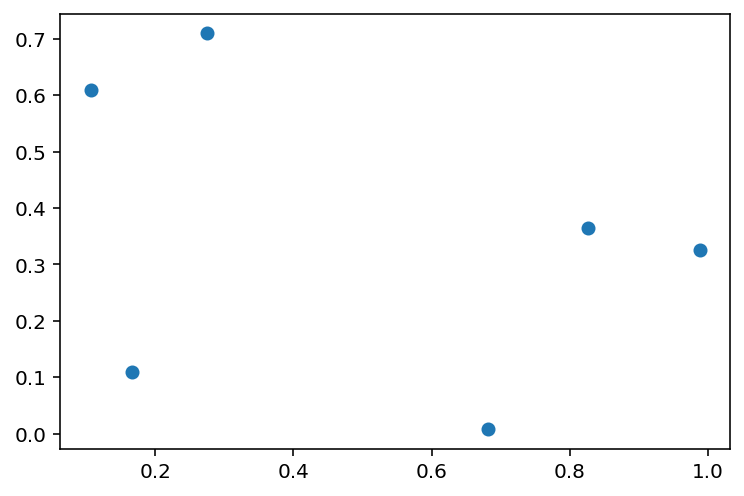

In [56]:
N = 5
puntos = np.random.rand(N+1,2)
plt.plot(puntos[:,0],puntos[:,1],"o")

## Creamos la matriz
v1 = np.zeros((N+2,1))
v1[:N+1,0] = puntos[:,0]
v1[N+1,0] = puntos[0,0]

v2 = np.zeros((N+2,1))
v2[:N+1,0] = puntos[:,1]
v2[N+1,0] = puntos[0,1]


d = np.sqrt((v1.T-v1)**2 + (v2.T-v2)**2)
#print(dist)

route: [0, 3, 2, 5, 1, 4, 6]


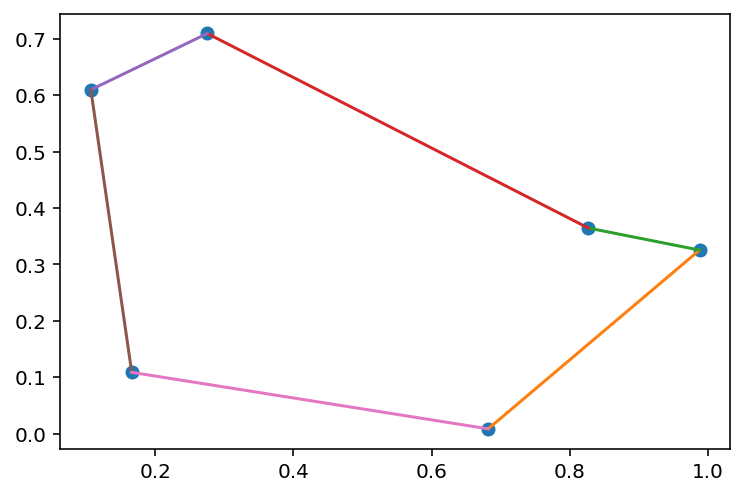

In [57]:

# size N + 2, because we have the initial point + N destinations + final point

lagrange = 4
#################################
#################################

# Model
mdl = Model('qRobot')
x = {(i,j,r): mdl.binary_var(name=f'x_{i}_{j}_{r}') 
     for i in range(N+2) for j in range(N+2)for r in range(3)}

# Objetive function + constraint 5
qRobot_Objective_Function = mdl.sum(x[(i,j,1)]*d[i,j] 
                                    for i in range(N+2) for j in range(N+2)) 

for i in range(1, N+1):
    for j in range(1,N+1):
        for k in range(1,N+1):
            if i!=j and i !=k and j !=k:
                qRobot_Objective_Function += lagrange *(x[(j,i,2)] * x[(k,j,2)] - 
                                              x[(j,i,2)] * x[(k,i,2)] -
                                              x[(k,j,2)] * x[(k,i,2)] +
                                              x[k,i,2])
            
#Minimize our Objective funtion. 
mdl.minimize(qRobot_Objective_Function)


# constraint 1
# For each (i,j) one and only one of the 3 cases of r must be given

for i in range(N+2):
    for j in range(N+2):
        if j != i:
            mdl.add_constraint(mdl.sum(x[i, j, r] for r in range(3)) == 1)

# constraint 2
# Each node must be exited once.

for i in range(N+1):
    lista = list(range(i))+ list(range(i+1,N+2))
    mdl.add_constraint(mdl.sum(x[i, j, 1] for j in lista) == 1)

# constraint 3 
# Each node must be reached once.
                       
for j in range(1,N+2):
    lista = list(range(j))+ list(range(j+1,N+1))
    mdl.add_constraint(mdl.sum(x[i, j, 1] for i in lista) == 1)

# constraint 4
# If node i is reached before j,then node j is reached after i.

for i in range(N+2):
    for j in range(N+2):
        if i != j:
            mdl.add_constraint(x[i,j,2] + x[j,i,2] == 1)
             

# optimizing the model
mdl.parameters.timelimit = 30
exact_solution = mdl.solve(log_output = False)

sol = exact_solution.as_dict()


# get edges

edges = []
for i in sol:
    var = str(i).split("_")
    if var[-1] == "1":
        edges.append([int(var[1]), int(var[2])])
        

# get route

initial = edges[0]
route = initial
while len(route) != N+2:
    for edge in edges[1:]:
        if edge[0] == route[-1]:
            route.append(edge[1])
            continue
    
print("route:", route)


route[len(route)-1] = 0

plt.plot(puntos[:,0],puntos[:,1],"o")
for ii in range(len(route)-1):
    plt.plot(puntos[(route[ii],route[ii+1]),0],puntos[(route[ii],route[ii+1]),1])

In [58]:
route

[0, 3, 2, 5, 1, 4, 0]

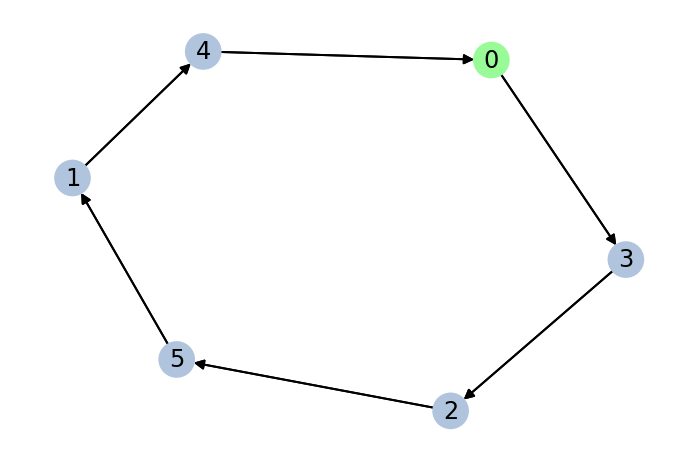

In [59]:
import numpy as np
import networkx as nx

colores = ["r","grey","y"]
#aux = nx.from_numpy_matrix(np.array(dist))
#aux = nx.DiGraph(aux)
#pos = nx.spring_layout(aux)
#G = nx.DiGraph(G)
G = nx.DiGraph()
#rows, cols = np.where(sol == 1)
#edges = list(zip(rows.tolist(), cols.tolist()))
#edges2 = [(x[0], x[1]%len(puntos)) for x in edges]

edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
#pos2 = {int(i): puntos[i] for i in range(len(puntos))}
#nx.draw(G, node_size=500, with_labels=True)
#nx.draw_networkx_nodes(G, pos2)
G.add_edges_from(edges)
pos2 = nx.spring_layout(G) #PARFAIT
nx.draw_networkx_labels(G, pos2)

nx.draw_networkx_edges(G, pos2)

node_colors = ["lightsteelblue" for _ in range(len(G.nodes))]
node_colors[0] = "palegreen"

nx.draw(G, pos2, node_color = node_colors)
plt.show()